In [435]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess
import zipfile

from torchvision import transforms, models

seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [436]:
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['platesv2']
After zip extraction:
['val', '__MACOSX', 'train', 'submission.csv', '.virtual_documents', 'plates', '__notebook_source__.ipynb']


In [437]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [438]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3263.20it/s]


In [439]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),

    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [440]:
len(train_dataloader), len(train_dataset)

(4, 32)

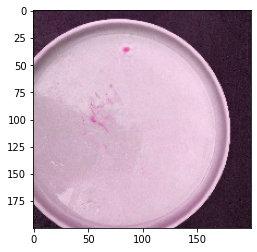

In [441]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

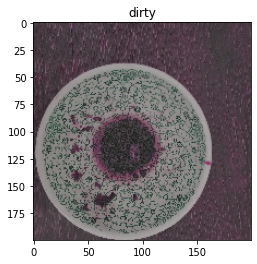

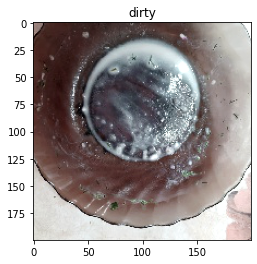

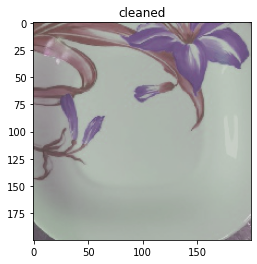

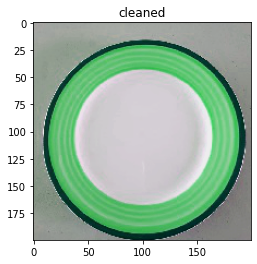

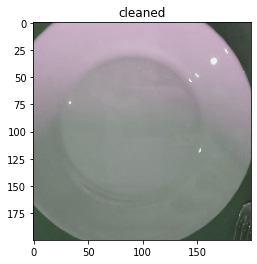

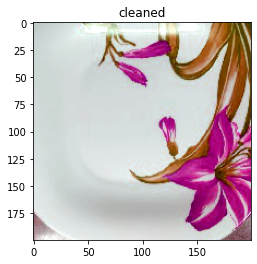

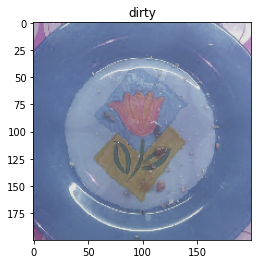

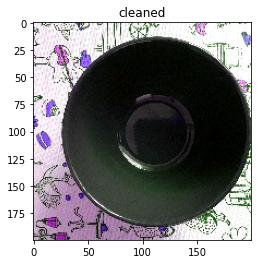

In [442]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [443]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [444]:
model = models.resnet18(pretrained=True)


In [445]:

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0313)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=50);


Epoch 0/49:


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

train Loss: 2.1908 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 2.9661 Acc: 0.5000
Epoch 1/49:



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

train Loss: 4.2579 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 2.5804 Acc: 0.5000
Epoch 2/49:



100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

train Loss: 2.5211 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6390 Acc: 0.7500
Epoch 3/49:



100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

train Loss: 2.2707 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 3.0675 Acc: 0.5000
Epoch 4/49:



100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

train Loss: 3.3136 Acc: 0.4375



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

val Loss: 2.0077 Acc: 0.5000
Epoch 5/49:



100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

train Loss: 1.6341 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 1.6690 Acc: 0.5000
Epoch 6/49:



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

train Loss: 0.7328 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.8339 Acc: 0.6250
Epoch 7/49:



100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

train Loss: 0.3270 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.7066 Acc: 0.7500
Epoch 8/49:



100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

train Loss: 0.4250 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.7076 Acc: 0.7500
Epoch 9/49:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.1780 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.6414 Acc: 0.7500
Epoch 10/49:



100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

train Loss: 0.1691 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

val Loss: 0.6255 Acc: 0.7500
Epoch 11/49:



100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

train Loss: 0.1893 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.5876 Acc: 0.7500
Epoch 12/49:



100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

train Loss: 0.0996 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.5928 Acc: 0.7500
Epoch 13/49:



100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

train Loss: 0.1250 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.5960 Acc: 0.7500
Epoch 14/49:



100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

train Loss: 0.2264 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.5687 Acc: 0.7500
Epoch 15/49:



100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

train Loss: 0.1556 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.5616 Acc: 0.7500
Epoch 16/49:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.2457 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.5184 Acc: 0.7500
Epoch 17/49:



100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

train Loss: 0.2483 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

val Loss: 0.5497 Acc: 0.7500
Epoch 18/49:



100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

train Loss: 0.1175 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.5679 Acc: 0.7500
Epoch 19/49:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.3278 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.5740 Acc: 0.7500
Epoch 20/49:



100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

train Loss: 0.3013 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

val Loss: 0.6099 Acc: 0.7500
Epoch 21/49:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.1827 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 0.6411 Acc: 0.7500
Epoch 22/49:



100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

train Loss: 0.2055 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

val Loss: 0.6286 Acc: 0.7500
Epoch 23/49:



100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

train Loss: 0.1390 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6499 Acc: 0.7500
Epoch 24/49:



100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

train Loss: 0.4951 Acc: 0.7812



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

val Loss: 0.6259 Acc: 0.7500
Epoch 25/49:



100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

train Loss: 0.1316 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.6098 Acc: 0.7500
Epoch 26/49:



100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

train Loss: 0.2356 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

val Loss: 0.6310 Acc: 0.7500
Epoch 27/49:



100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

train Loss: 0.2309 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6816 Acc: 0.7500
Epoch 28/49:



100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

train Loss: 0.4684 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

val Loss: 0.6466 Acc: 0.7500
Epoch 29/49:



100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

train Loss: 0.1497 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

val Loss: 0.6323 Acc: 0.7500
Epoch 30/49:



100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

train Loss: 0.3462 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6667 Acc: 0.7500
Epoch 31/49:



100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

train Loss: 0.1837 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

val Loss: 0.6197 Acc: 0.7500
Epoch 32/49:



100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

train Loss: 0.3637 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

val Loss: 0.6644 Acc: 0.7500
Epoch 33/49:



100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

train Loss: 0.1241 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6535 Acc: 0.7500
Epoch 34/49:



100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

train Loss: 0.0930 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.6087 Acc: 0.7500
Epoch 35/49:



100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

train Loss: 0.1058 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.5864 Acc: 0.7500
Epoch 36/49:



100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

train Loss: 0.1058 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.6030 Acc: 0.7500
Epoch 37/49:



100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

train Loss: 0.3571 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

val Loss: 0.6192 Acc: 0.7500
Epoch 38/49:



100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

train Loss: 0.1874 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

val Loss: 0.6541 Acc: 0.7500
Epoch 39/49:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.2612 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6424 Acc: 0.7500
Epoch 40/49:



100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

train Loss: 0.2047 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.6087 Acc: 0.7500
Epoch 41/49:



100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

train Loss: 0.1624 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.6074 Acc: 0.7500
Epoch 42/49:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.1823 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.6158 Acc: 0.7500
Epoch 43/49:



100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

train Loss: 0.1186 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.5955 Acc: 0.7500
Epoch 44/49:



100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

train Loss: 0.1266 Acc: 0.9688



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

val Loss: 0.6495 Acc: 0.7500
Epoch 45/49:



  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset


In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})


In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.59 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)


In [ ]:
submission_df.to_csv('submission.csv')


In [ ]:
!rm -rf train val test
